In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", None)
%matplotlib inline

DATA = Path("../data")
OUT  = Path("../reports/figures")
OUT.mkdir(parents=True, exist_ok=True)

users = pd.read_csv("../data/users.csv")
transactions = pd.read_csv("../data/transactions.csv")


In [22]:
transactions["Datetime"] = pd.to_datetime(
    transactions["Year"].astype(int).astype(str) + "-" +
    transactions["Month"].astype(int).astype(str).str.zfill(2) + "-" +
    transactions["Day"].astype(int).astype(str).str.zfill(2) + " " +
    transactions["Time"].astype(str),
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)
transactions["hour"] = transactions["Datetime"].dt.hour
transactions["Amount"] = pd.to_numeric(transactions["Amount"], errors="coerce")

users["_income_num"] = (users["Yearly Income - Person"].astype(str)
                        .str.replace("$","", regex=False)
                        .str.replace(",","", regex=False)
                        .astype(float))

In [23]:
df = transactions.merge(users[["User","Gender","_income_num"]], on="User", how="left")
df = df.dropna(subset=["Amount","Datetime"])

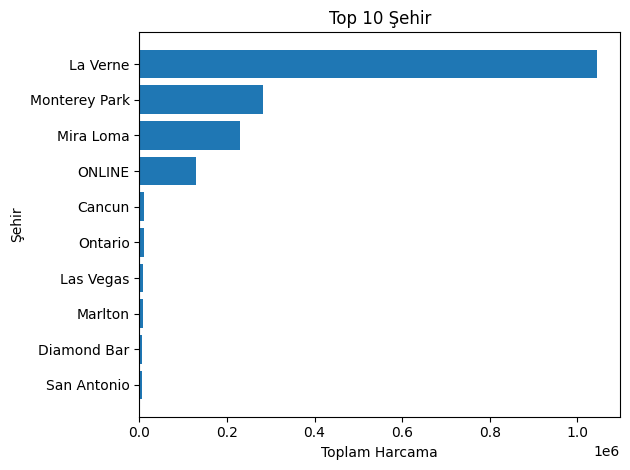

In [24]:
top_cities = (df.groupby("Merchant City")["Amount"]
                .sum().sort_values(ascending=False).head(10))
plt.figure()
plt.barh(top_cities.index[::-1], top_cities.values[::-1])
plt.xlabel("Toplam Harcama"); plt.ylabel("Şehir"); plt.title("Top 10 Şehir")
plt.tight_layout()
plt.savefig(OUT/"top10_cities.png", dpi=160)
plt.show()

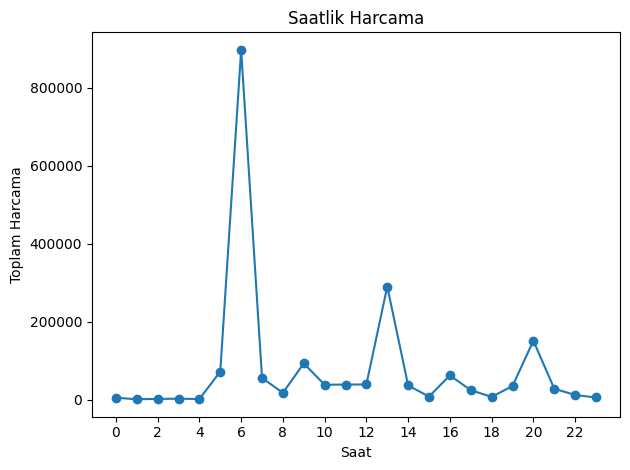

In [25]:
hourly = df.groupby("hour")["Amount"].sum().reindex(range(24), fill_value=0)
plt.figure()
plt.plot(hourly.index, hourly.values, marker="o")
plt.xlabel("Saat"); plt.ylabel("Toplam Harcama"); plt.title("Saatlik Harcama")
plt.xticks(range(0,24,2))
plt.tight_layout()
plt.savefig(OUT/"hourly_spend.png", dpi=160)
plt.show()

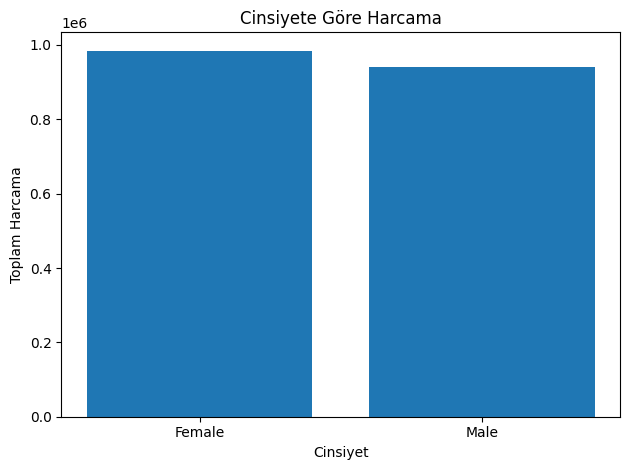

In [26]:
by_gender = df.groupby("Gender")["Amount"].sum().sort_values(ascending=False)
plt.figure()
plt.bar(by_gender.index.astype(str), by_gender.values)
plt.xlabel("Cinsiyet"); plt.ylabel("Toplam Harcama"); plt.title("Cinsiyete Göre Harcama")
plt.tight_layout()
plt.savefig(OUT/"gender_spend.png", dpi=160)
plt.show()

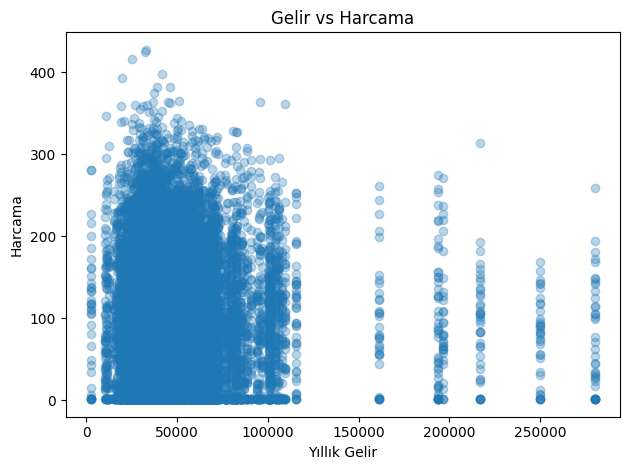

In [27]:
plt.figure()
plt.scatter(df["_income_num"], df["Amount"], alpha=0.3)
plt.xlabel("Yıllık Gelir"); plt.ylabel("Harcama"); plt.title("Gelir vs Harcama")
plt.tight_layout()
plt.savefig(OUT/"income_scatter.png", dpi=160)
plt.show()

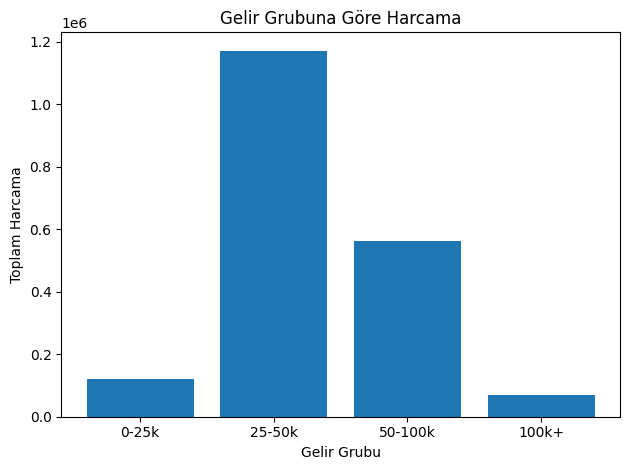

In [30]:
bins   = [0, 25_000, 50_000, 100_000, np.inf]
labels = ["0-25k","25-50k","50-100k","100k+"]
df["income_group"] = pd.cut(df["_income_num"], bins=bins, labels=labels, right=False)
by_group = df.groupby("income_group", observed=False)["Amount"].sum().reindex(labels)
plt.figure()
plt.bar(by_group.index.astype(str), by_group.values)
plt.xlabel("Gelir Grubu"); plt.ylabel("Toplam Harcama"); plt.title("Gelir Grubuna Göre Harcama")
plt.tight_layout()
plt.savefig(OUT/"income_group.png", dpi=160)
plt.show()

In [29]:
corr = df[["_income_num","Amount"]].corr().iloc[0,1]
summary = {
    "En çok harcama yapılan şehir": top_cities.index[0] if len(top_cities) else None,
    "Tepe saat": int(hourly.idxmax()),
    "Toplam harcamada önde olan cinsiyet": None if by_gender.empty else str(by_gender.index[0]),
    "Gelir-harcama korelasyonu": float(round(corr, 3)),
    "En yüksek harcama yapan gelir grubu": None if by_group.dropna().empty else str(by_group.idxmax()),
    "Şekiller klasörü": str(OUT.resolve())
}
summary

{'En çok harcama yapılan şehir': 'La Verne',
 'Tepe saat': 6,
 'Toplam harcamada önde olan cinsiyet': 'Female',
 'Gelir-harcama korelasyonu': -0.007,
 'En yüksek harcama yapan gelir grubu': '25-50k',
 'Şekiller klasörü': 'C:\\Users\\Efee\\Desktop\\spend-analysis\\patika-spend-analysis\\reports\\figures'}